In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_width, img_height = 299, 299  # Xception model's default input size
num_classes = 3


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2


# Create an image generator with augmentation operations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    rotation_range=30,  # Rotation range
)

# Generator for training data
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Car_Damage_Severity_Dataset/training",
    target_size=(299, 299),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',  # Change to 'binary' for binary classification
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    "/content/drive/MyDrive/Car_Damage_Severity_Dataset/validation",
    target_size=(299, 299),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',  # Change to 'binary' for binary classification
)

Found 1383 images belonging to 3 classes.
Found 258 images belonging to 3 classes.


In [ ]:
# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add your custom classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

In [ ]:
# Create the fine-tuned model
model = models.Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import math

# Define the ModelCheckpoint callback
checkpoint_path = '/content/drive/MyDrive' + '/best_model_xception_damage_severity.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Calculate steps_per_epoch
steps_per_epoch = math.ceil(len(train_generator) / train_generator.batch_size)

# Calculate validation_steps
validation_steps = math.ceil(len(validation_generator) / validation_generator.batch_size)

# Use the callback when calling fit_generator
hist = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=70,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint]
)


<ipython-input-11-ca88fdca25f4>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/70
2/2 [==============================] - ETA: 0s - loss: 1.1680 - accuracy: 0.3750 
Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to /content/drive/MyDrive/best_model_xception_damage_severity.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 37s 19s/step - loss: 1.1680 - accuracy: 0.3750 - val_loss: 1.0413 - val_accuracy: 0.4375
Epoch 2/70
2/2 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.4375
Epoch 2: val_accuracy improved from 0.43750 to 0.53125, saving model to /content/drive/MyDrive/best_model_xception_damage_severity.h5
2/2 [==============================] - 26s 19s/step - loss: 1.0675 - accuracy: 0.4375 - val_loss: 0.9560 - val_accuracy: 0.5312
Epoch 3/70
2/2 [==============================] - ETA: 0s - loss: 1.2688 - accuracy: 0.3906
Epoch 3: val_accuracy improved from 0.53125 to 0.59375, saving model to /content/drive/MyDrive/best_model_xception_damage_severity.h5
2/2 [==============================] - 22s 15s/step - loss: 1.2688 - accuracy: 0.3906 - val_loss: 0.8997 - val_accuracy: 0.5938
Epoch 4/70
2/2 [==============================] - ETA: 0s - loss: 1.1047 - accuracy: 0.3125
Epoch 4: val_accuracy did not improve from 0.59375
2/2 [================

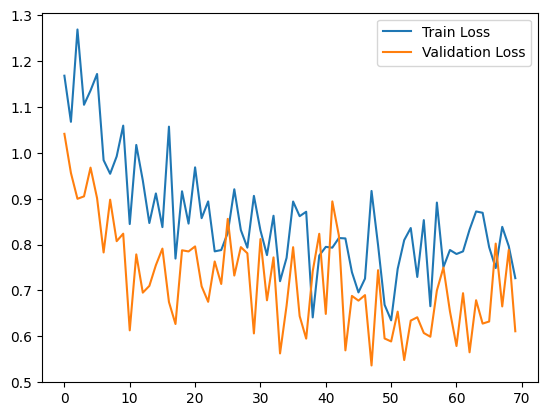

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["loss"], label = "Train Loss")
plt.plot(hist.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.show()

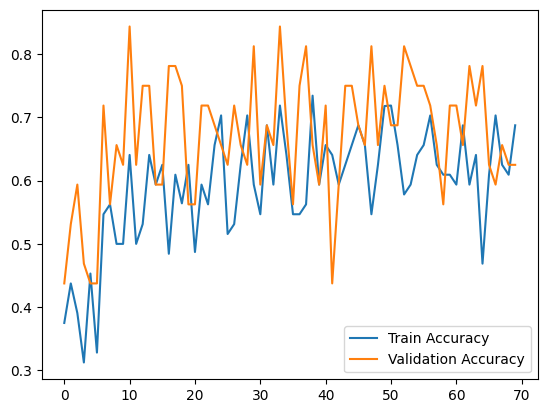

In [ ]:
plt.plot(hist.history["accuracy"], label = "Train Accuracy")
plt.plot(hist.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/best_model_xception_damage_severity.h5')


In [ ]:
class_names=list(train_generator.class_indices.keys())
class_names

['01-minor', '02-moderate', '03-severe']

1/1 [==============================] - 1s 1s/step
Predicted Class Index: 2


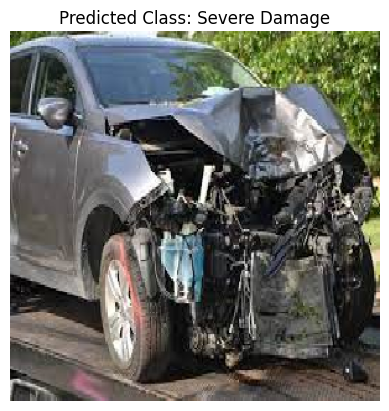

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_xception_damage_severity.h5')

# Load and preprocess the image
img_path = '/content/téléchargement (2).jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(299, 299))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class Index: {predicted_class}")

# Display the image
plt.imshow(img)
plt.axis('off')

# Display the predicted class message
if predicted_class == 0:
    plt.title("Predicted Class: Minor Damage")
elif predicted_class == 1:
    plt.title("Predicted Class: Moderate Damage")
elif predicted_class == 2:
    plt.title("Predicted Class: Severe Damage")

plt.show()


1/1 [==============================] - 1s 710ms/step
Predicted Class Index: 0


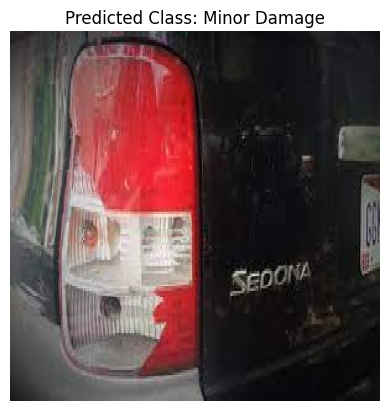

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_xception_damage_severity.h5')

# Load and preprocess the image
img_path = '/content/téléchargement (3).jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(299, 299))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class Index: {predicted_class}")

# Display the image
plt.imshow(img)
plt.axis('off')

# Display the predicted class message
if predicted_class == 0:
    plt.title("Predicted Class: Minor Damage")
elif predicted_class == 1:
    plt.title("Predicted Class: Moderate Damage")
elif predicted_class == 2:
    plt.title("Predicted Class: Severe Damage")

plt.show()


1/1 [==============================] - 1s 730ms/step
Predicted Class Index: 0


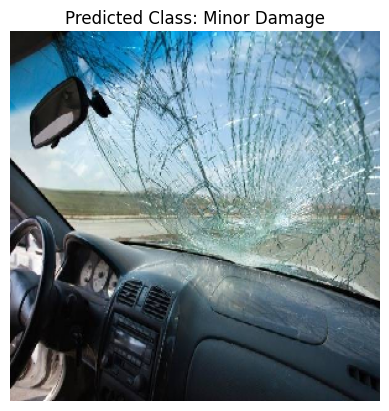

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_xception_damage_severity.h5')

# Load and preprocess the image
img_path = '/content/carcare_1013111_600.jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(299, 299))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class Index: {predicted_class}")

# Display the image
plt.imshow(img)
plt.axis('off')

# Display the predicted class message
if predicted_class == 0:
    plt.title("Predicted Class: Minor Damage")
elif predicted_class == 1:
    plt.title("Predicted Class: Moderate Damage")
elif predicted_class == 2:
    plt.title("Predicted Class: Severe Damage")

plt.show()


1/1 [==============================] - 1s 748ms/step
Predicted Class Index: 1


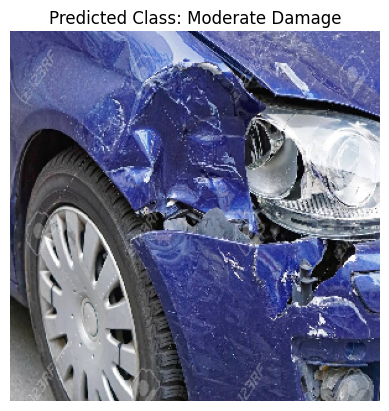

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_xception_damage_severity.h5')

# Load and preprocess the image
img_path = '/content/98439718-damaged-car-front-after-traffic-accident.jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(299, 299))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class Index: {predicted_class}")

# Display the image
plt.imshow(img)
plt.axis('off')

# Display the predicted class message
if predicted_class == 0:
    plt.title("Predicted Class: Minor Damage")
elif predicted_class == 1:
    plt.title("Predicted Class: Moderate Damage")
elif predicted_class == 2:
    plt.title("Predicted Class: Severe Damage")

plt.show()


1/1 [==============================] - 1s 730ms/step
Predicted Class Index: 2


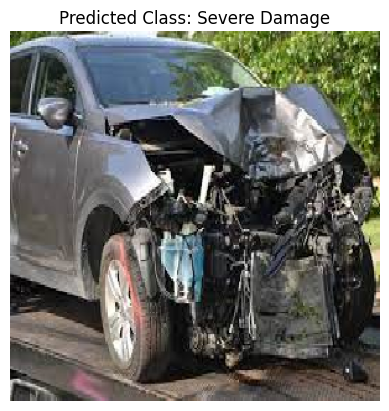

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/best_model_xception_damage_severity.h5')

# Load and preprocess the image
img_path = '/content/téléchargement (2).jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(299, 299))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions, axis=1)[0]
print(f"Predicted Class Index: {predicted_class}")

# Display the image
plt.imshow(img)
plt.axis('off')

# Display the predicted class message
if predicted_class == 0:
    plt.title("Predicted Class: Minor Damage")
elif predicted_class == 1:
    plt.title("Predicted Class: Moderate Damage")
elif predicted_class == 2:
    plt.title("Predicted Class: Severe Damage")

plt.show()
